# 안녕하세요^^ 
# AIVLE 미니 프로젝트에 오신 여러분을 환영합니다.
* 본 과정에서는 실제 사례와 데이터를 기반으로 문제를 해결하는 전체 과정을 자기 주도형 실습으로 진행해볼 예정입니다.
* 앞선 교육과정을 정리하는 마음과 지금까지 배운 내용을 바탕으로 문제 해결을 해볼게요!
* 미니 프로젝트를 통한 문제 해결 과정 'A에서 Z까지', 지금부터 시작합니다!

### 문제 정의
> 문자 메시지 스팸 분류 문제<br>
> 1. 문자 메시지 데이터 분석
> 2. 스팸 분류 모델 성능 평가
### 학습 데이터
> * train/validation : spam.csv
> * test : spam_test_text.csv
### 변수 소개
> * text : 문자 메시지
> * label : 스팸여부

### References
> * 한국어 처리
>> * [konlpy - 한국어 처리 라이브러리](https://konlpy.org/ko/latest/)
>> * [한국어 품사 태그 비교표](https://docs.google.com/spreadsheets/d/1OGAjUvalBuX-oZvZ_-9tEfYD2gQe7hTGsgUpiiBSXI8/edit#gid=0)
>> * [한국어 품사 태깅 성능 비교](https://konlpy.org/ko/latest/morph/#comparison-between-pos-tagging-classes)
>> * [한국어 시스템 사전](https://konlpy.org/ko/latest/data/#corpora)

> * 자연어 처리
>> * [NLTK](https://www.nltk.org/book/)
>> * [gensim](https://radimrehurek.com/gensim/)
>> * [Google guide](https://developers.google.com/machine-learning/guides/text-classification/step-2)
>> * [WordCloud](https://amueller.github.io/word_cloud/)

----

# 데이터 탐색부터 먼저 시작해보겠습니다.

---

### 0. 라이브러리 설치 및 불러오기

In [1]:
# 필요 라이브러리부터 설치할께요.
!pip install konlpy pandas seaborn gensim wordcloud

In [2]:
## import sklearn
import pandas as pd

import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
import tensorflow as tf
fm.findSystemFonts()
plt.rcParams['font.family']= ["NanumGothicCoding"]
plt.rcParams["axes.unicode_minus"]=False
# GPU 환경 설정하기
# assert tf.test.is_gpu_available() == True, 'GPU 설정을 확인하세요.'
print(tf.config.list_physical_devices('GPU'))
print(tf.config.list_logical_devices('GPU'))

[]
[]


### 1. 데이터 준비
#### 1-1. 데이터 가져오기

In [4]:
# 데이터를 가져옵니다.
import pandas as pd

data = pd.read_csv('spam.csv')

### 1-2. 데이터 확인하기

In [5]:
# head 함수를 이용해 데이터를 확인해봅니다. (띄어쓰기가 되어 있지 않음을 알 수 있어요.)
data.head()

,text,label
0,[Web발신]박춘규회원님손절주식은그만월급배만드는법http://lco.jp/eA,spam
1,[Web발신]골든브릿지에서손실을보셨나요??http://bitly.kr/bRGtq[FW],spam
2,[Web발신][대//박]가(.원)입코(WN)드MEP.com,spam
3,[Web발신](광고)이정미님아직도주식하시나요http://pf.kakao.com/_u...,spam
4,[Web발신]송승용님사람이모이는곳에는이유가있습니다하루~정보공개is.gd/JsJP,spam


In [6]:
# info() 함수를 이용해서 데이터의 정보를 확인합니다.
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20100 entries, 0 to 20099
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    20089 non-null  object
 1   label   20100 non-null  object
dtypes: object(2)
memory usage: 314.2+ KB


<AxesSubplot:>

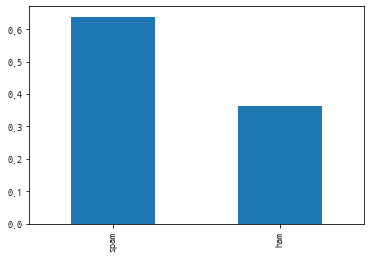

In [63]:
# label 데이터 분포를 확인합니다.
data['label'].value_counts(normalize=True).plot.bar()

In [9]:
# descibe 함수를 이용해서 기본 정보를 확인합니다.
data.describe()

,text,label
count,20089,20100
unique,18386,2
top,[Web발신]회원님예치금원보유중보관기간끝납니다해저.한국<<안심다운로드코드,spam
freq,107,12817


#### 1-3. 결측치 제거

In [10]:
# 결측치를 제거한 후 확인합니다.
data.isnull().sum()

text     11
label     0
dtype: int64

In [11]:
data = data.dropna(axis=0)
data.isnull().sum()

text     0
label    0
dtype: int64

### 2. 텍스트 데이터 분석

#### 2-1. 텍스트 길이 분포 

In [13]:
# konlpy를 활용하여 태깅 클래스를 불러옵니다.
import nltk
from konlpy.tag import Mecab
mecab = Mecab()

#### 2-2. 형태소/명사 추출

In [17]:
data.head()

,text,label
0,[Web발신]박춘규회원님손절주식은그만월급배만드는법http://lco.jp/eA,spam
1,[Web발신]골든브릿지에서손실을보셨나요??http://bitly.kr/bRGtq[FW],spam
2,[Web발신][대//박]가(.원)입코(WN)드MEP.com,spam
3,[Web발신](광고)이정미님아직도주식하시나요http://pf.kakao.com/_u...,spam
4,[Web발신]송승용님사람이모이는곳에는이유가있습니다하루~정보공개is.gd/JsJP,spam


In [28]:
type(data['text'])

pandas.core.series.Series

In [31]:
data_txt = data['text'].to_string()

In [34]:
# 태깅 클래스를 활용하여 형태소/명사를 추출합니다.

# 형태소
morphs_data = mecab.morphs(data_txt)
print(len(morphs_data))
morphs_data[:10]

491357


['0', '[', 'Web', '발신', ']', '박춘규', '회원', '님', '손절', '주식']

In [35]:
# 명사
nouns_data = mecab.nouns(data_txt)
print(len(nouns_data))
nouns_data[:10]

179722


['발신', '박춘규', '회원', '손절', '주식', '월급', '배', '법', '발신', '골든']

In [9]:
# Number of Samples / Number of words per sample 확인합니다.
# https://developers.google.com/machine-learning/guides/text-classification/step-2-5 참고


#### 2-3. NLTK Text로 변환

In [36]:
# Tokenize한 문자 데이터를 하나의 nltk.Text로 변환합니다.
nltk_morphs_data = nltk.Text(morphs_data)
nltk_nouns_data = nltk.Text(nouns_data)

In [58]:
type(nltk_nouns_data)

nltk.text.Text

In [59]:
nltk_nouns_data

<Text: 발신 박춘규 회원 손절 주식 월급 배 법...>

#### 2-4. Frequency plot

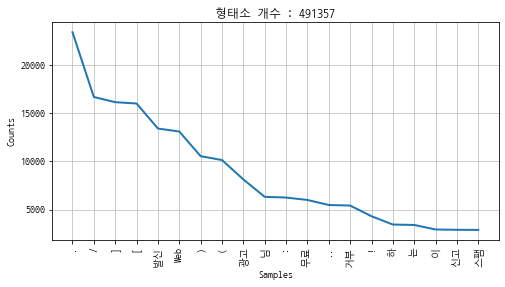

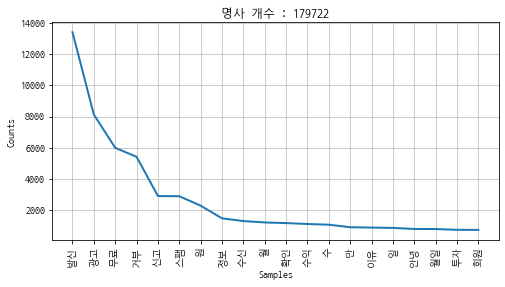

In [38]:
# 형태소/명사 추출 각각 단어 분포를 확인합니다.
plt.figure(figsize=(8,4))
plt.title("형태소 개수 : " + str(len(nltk_morphs_data.tokens)))
nltk_morphs_data.plot(20)
plt.figure(figsize=(8,4))
plt.title("명사 개수 : " + str(len(nltk_nouns_data.tokens)))
nltk_nouns_data.plot(20)
plt.show()

#### 2-5. Similar words

In [39]:
# 어떤 단어(스팸, 주식...)의 유사 단어를 확인합니다.
nltk_morphs_data.similar('스팸')

돈 가입금 왼쪽


In [40]:
# 어떤 단어(스팸, 주식...)의 유사 단어를 확인합니다.
nltk_nouns_data.similar('주식')

광고 발신 무료 월 안녕 문자 국외 회원 원 일 문의 돈 청개구리 한국 시간 단기 종목 주말 참여 팀장


#### 2-6. Vocabulary

In [42]:
# 단어 사전을 확인합니다.
nltk_morphs_data.concordance('스팸', width=20, lines=5)

Displaying 5 of 2885 matches:
JP 5 MMS 스팸 신고 사진 사진
부 10 MMS 스팸 신고 사모 님 
. 16 MMS 스팸 신고 전주 김해
? 24 MMS 스팸 신고 [ Web
. 37 MMS 스팸 신고 겜 블 시


In [43]:
nltk_nouns_data.concordance('스팸', width=20, lines=5)

Displaying 5 of 2885 matches:
하루 정보 공개 스팸 신고 사진 사진
손실 무료 거부 스팸 신고 사모 삼송
비결 밴드 확인 스팸 신고 전주 김해
정릉 모바일 앱 스팸 신고 발신 단기
 손순 평 확인 스팸 신고 겜 블 시


#### 2-7. Collocation

In [44]:
# 연어(collocation)들을 확인합니다.
nltk_morphs_data.collocations(window_size=5)
print("*"*50)
nltk_nouns_data.collocations(window_size=5)

kakao com; hoy HQv; http nazr; Web Web; MMS Web; 다이소 선정릉; https tuney;
홍지윤 종잣돈; 선정릉 모바일; 다이소 모바일; GCtvj friend; hoy rrzSz; tuney mdFoyK; com
GCtvj; 선정릉 http; 다이소 http; http bIt; MyOTP myotp; KMC 미확인; ㅋㅋㅋ ㅋㅋㅋ
**************************************************
다이소 선정릉; 홍지윤 종잣돈; 선정릉 모바일; 다이소 모바일; 이재훈 담당자; 현금원 만료일; 김정태 서포터; 김지훈
관리사; 스파클 선정릉; 스파클 다이소; 스파클 모바일; 전업주부 장영옥; 스포츠 실시간; 컨설팅 이페이; 플란트 플란트;
상품명 세탁기; 상품명 에어컨; 이동하 주세요; 네이처 컬렉션; 전업주부 강현주


#### 3. WordCloud

#### 3-1. Morphs vs Nouns

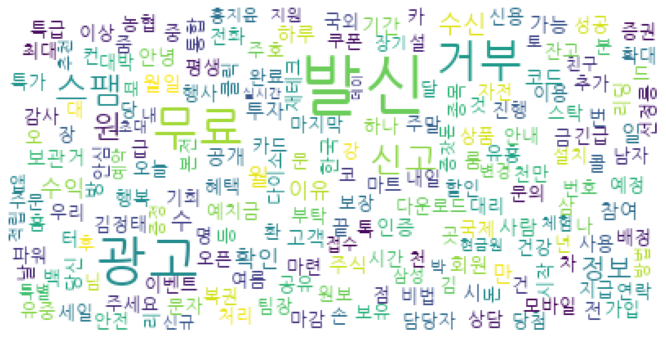

In [45]:
# 형태소와 명사 추출 각각에 대해 wordcloud로 확인합니다.

import matplotlib.font_manager as font_manager
from wordcloud import WordCloud
NGC_path = font_manager.findfont('NanumGothicCoding')
#wc = WordCloud(font_path=NGC_path,max_font_size=40).generate(constitution)
wc = WordCloud(font_path=NGC_path,max_font_size=40,background_color="white", collocations=False).generate(' '.join(nltk_nouns_data)) # 리스트 -> 띄어쓰기를 기준으로 string화
# collocations : 중복 제거
plt.figure(figsize=(12,6))
plt.imshow(wc)
plt.axis("off")
plt.show()

#### 3-2. Ham vs Spam

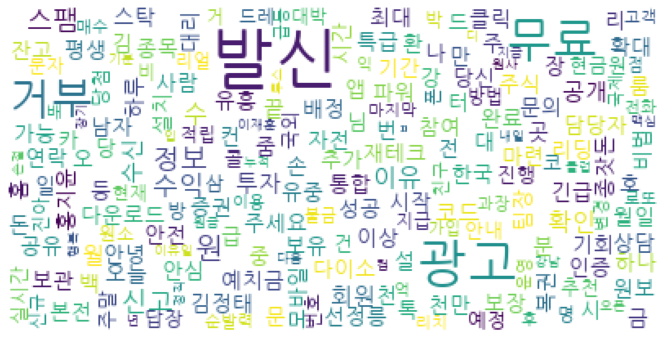

In [51]:
# 명사 추출한 결과를 Ham과 Spam에 대해 wordcloud로 확인합니다.

# spam
data_spam = data.loc[data['label'] == 'spam']
data_spam_txt = data_spam['text'].to_string()

# 명사
nouns_spam = mecab.nouns(data_spam_txt)
nltk_spam_data = nltk.Text(nouns_spam)

# wordcloud
NGC_path = font_manager.findfont('NanumGothicCoding')
wc = WordCloud(font_path=NGC_path,max_font_size=40,background_color="white", collocations=False).generate(' '.join(nltk_spam_data))
plt.figure(figsize=(12,6))
plt.imshow(wc)
plt.axis("off")
plt.show()

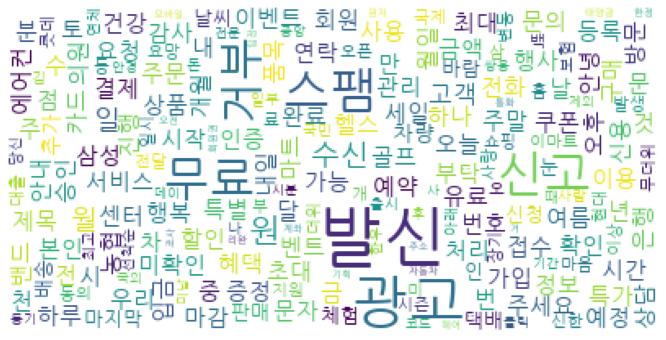

In [52]:
# 명사 추출한 결과를 Ham과 Spam에 대해 wordcloud로 확인합니다.

# ham
data_ham = data.loc[data['label'] == 'ham']
data_ham_txt = data_ham['text'].to_string()

# 명사
nouns_ham = mecab.nouns(data_ham_txt)
nltk_ham_data = nltk.Text(nouns_ham)

# wordcloud
NGC_path = font_manager.findfont('NanumGothicCoding')
wc = WordCloud(font_path=NGC_path,max_font_size=40,background_color="white", collocations=False).generate(' '.join(nltk_ham_data))
plt.figure(figsize=(12,6))
plt.imshow(wc)
plt.axis("off")
plt.show()